## This Specific Notebook
* Notebook with visuals from Visualize
* https://www.ncdc.noaa.gov/cdo-web/
* http://climod2.nrcc.cornell.edu/
    * Daily data listing
    * Search Bradley International Airport
* Note:
    * T: Trace amount- Less than 0.01" precipitation; less than 0.1" snowfall; less than 1" snow depth.
    * S: Subsequent- Indicates the observation is missing, but is included in a subsequent value.
    * A: Accumulated- Indicates an accumulated value which includes the current day and any immediately preceeding missing days (starting with a day flagged by "S").
    * M: Missing.
* Note:
    * I just copied and pasted the data from 12.27.2020 to 1.3.2021 in to the existing excel file with all the dates so I had to drop then add back in Year, Month, Day columns.
    * Going forward I should just copy and paste the new dates into a csv file then merge them into a clean csv for analysis

___

# Importing Libraries and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import os
sns.set()

#from fbprophet import Prophet

In [2]:
df = pd.read_csv('Bradley_1_1_1980_12_31_2021_Clean.csv')

In [3]:
# df = df.drop(['Unnamed: 0'], axis = 1)

### Convert Date to datetime

In [4]:
df[['Date']] = df[['Date']].apply(pd.to_datetime)

___

# Analysis

In [5]:
df1 = df[['Date', 'AvgTemperature']]
df1

,Date,AvgTemperature
0,1980-01-01,28.0
1,1980-01-02,31.5
2,1980-01-03,26.0
3,1980-01-04,19.5
4,1980-01-05,25.0
...,...,...
15336,2021-12-27,40.0
15337,2021-12-28,40.0
15338,2021-12-29,37.5
15339,2021-12-30,41.5


In [6]:
df1.dtypes

Date              datetime64[ns]
AvgTemperature           float64
dtype: object

___

## Get the data set for prophet analysis

In [7]:
df1.rename(columns = {'Date':'ds', 'AvgTemperature': 'y'}, inplace = True)
df1

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4300: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,ds,y
0,1980-01-01,28.0
1,1980-01-02,31.5
2,1980-01-03,26.0
3,1980-01-04,19.5
4,1980-01-05,25.0
...,...,...
15336,2021-12-27,40.0
15337,2021-12-28,40.0
15338,2021-12-29,37.5
15339,2021-12-30,41.5


___

# Exploratory Data Analysis with Prophet Time Series Enabled Data

In [8]:
## Unique Numbers
df1.describe()

,y
count,15341.000000
mean,50.940747
std,18.280390
min,-2.000000
25%,36.500000
50%,51.500000
75%,67.000000
max,88.500000


<AxesSubplot:>

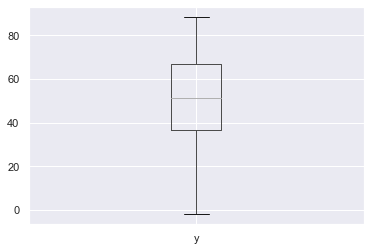

In [9]:
plt.figure()
df1.boxplot(['y'])

### Unique Numbers

In [10]:
df1.nunique()

ds    15341
y       179
dtype: int64

### List of unique Values

In [11]:
avg_temp = df1['y'].unique()

In [12]:
avg_temp

array([28. , 31.5, 26. , 19.5, 25. , 26.5, 28.5, 23. , 22. , 39.5, 38.5,
       32.5, 33.5, 30.5, 35.5, 39. , 31. , 27. , 27.5, 29. , 20.5, 17.5,
       15. , 14.5, 18.5, 17. , 24.5, 25.5, 13.5, 18. , 29.5, 37. , 30. ,
       35. , 34. , 21.5, 14. , 32. , 37.5, 36.5, 23.5, 24. , 40.5, 42. ,
       41. , 44. , 47.5, 45. , 43. , 41.5, 43.5, 44.5, 46.5, 47. , 51. ,
       54.5, 53. , 53.5, 54. , 56.5, 42.5, 49.5, 57. , 57.5, 50.5, 55. ,
       51.5, 55.5, 59. , 59.5, 61. , 58.5, 62.5, 50. , 61.5, 68. , 62. ,
       60. , 56. , 66.5, 64. , 74.5, 71. , 63.5, 60.5, 64.5, 70. , 74. ,
       65.5, 58. , 52.5, 70.5, 66. , 65. , 67. , 63. , 81.5, 78. , 77.5,
       80.5, 67.5, 69.5, 73.5, 76. , 68.5, 73. , 71.5, 76.5, 83. , 81. ,
       83.5, 84.5, 80. , 72. , 72.5, 77. , 75. , 79. , 78.5, 79.5, 75.5,
       82.5, 69. , 52. , 45.5, 48. , 46. , 34.5, 48.5, 33. , 40. , 36. ,
       38. , 22.5, 16. ,  7.5, 11.5, 13. ,  2. ,  2.5,  3.5, -2. , 19. ,
        8.5,  8. ,  4. , -0.5,  5.5, 12. , 16.5, 20

In [13]:
df1.isnull().any()

ds    False
y     False
dtype: bool

<Figure size 1152x576 with 0 Axes>

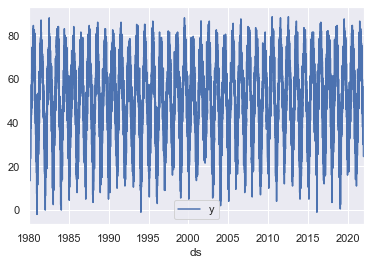

In [14]:
plt.figure(figsize = (16,8))
df1.plot(kind = 'line', x = 'ds', y = 'y')
plt.show()

___

# Time Series Analysis

# Prophet

### We fit the model by instantiating a new Prophet object. Any settings to the forecasting procedure are passed into the constructor.
* interval_width:
    * Biggest source of uncertainty in the forecast is the potential for future trend changes.
    * We assume that the future will see similar trend changes as the history.
    * We assume that the average frequency and magnitude of trend changes in the future will be the same as that which we observe in the history. We project these trend changes forward and by computing their distribution we obtain uncertainty intervals.
    * One property of this way of measuring uncertainty is that allowing higher flexibility in the rate, by increasing changepoint_prior_scale, will increase the forecast uncertainty. This is because if we model more rate changes in the history then we will expect more in the future, and makes the uncertainty intervals a useful indicator of overfitting.
    * The width of the uncertainty intervals (by default 80%) can be set using the parameter interval_width:
        * forecast = Prophet(interval_width=0.95).fit(df).predict(future)
* By default Prophet will only return uncertainty in the trend and observation noise. To get uncertainty in seasonality, you must do full Bayesian sampling. This is done using the parameter mcmc.samples (which defaults to 0).

In [15]:
# bash
# Install pystan with pip before using pip to install prophet
# pystan>=3.0 is currently not supported
#!pip install pystan==2.19.1.1
#!pip install prophet

from prophet import Prophet

In [16]:
m = Prophet()

In [17]:
m.fit(df1)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### Predictions are then made on a dataframe with a column ds containing the dates for which a prediction is to be made. 
* You can get a suitable dataframe that extends into the future a specified number of days using the helper method Prophet.make_future_dataframe. 
* By default it will also include the dates from the history, so we will see the model fit as well.
* Can also pass in the frequency into make_future_dataframe but this works fine with just preriods (for this example at least)

In [18]:
fb_api_future = m.make_future_dataframe(periods=30)

### The predict method will assign each row in the future a predicted value (yhat). 
* If you pass in historical dates, it will provide an in-sample fit. 
* The DataFrame (what we did above) of future dates is then used as input to the predict method of our fitted model.
#### Note
* A variation in values from the output presented below is to be expected as Prophet relies on Markov chain Monte Carlo (MCMC) methods to generate its forecasts. MCMC is a stochastic process, so values will be slightly different each time.

In [22]:
fb_api_forecast = m.predict(fb_api_future)
#forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(30)
#fb_api_forecast

In [23]:
fb_api_forecast[['ds', 'yhat']].tail(30)

,ds,yhat
15341,2022-01-01,30.310321
15342,2022-01-02,30.005234
15343,2022-01-03,30.071699
15344,2022-01-04,30.092090
15345,2022-01-05,29.913748
15346,2022-01-06,29.464561
15347,2022-01-07,29.161546
15348,2022-01-08,29.051321
15349,2022-01-09,28.713089
15350,2022-01-10,28.752884


### Prophet.plot
* Plot the forecast
* Pass in your forecast dataframe

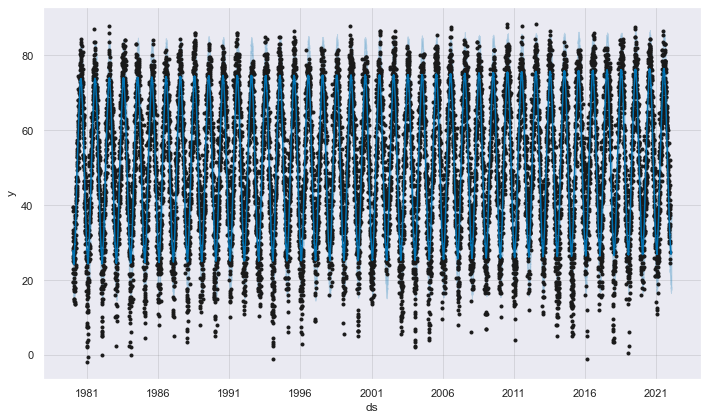

In [24]:
fig1 = m.plot(fb_api_forecast)

### Prophet.plot_components
* To see the forecast components
* By default you’ll see the trend, yearly seasonality, and weekly seasonality of the time series. 
* If you include holidays, you’ll see those here, too.

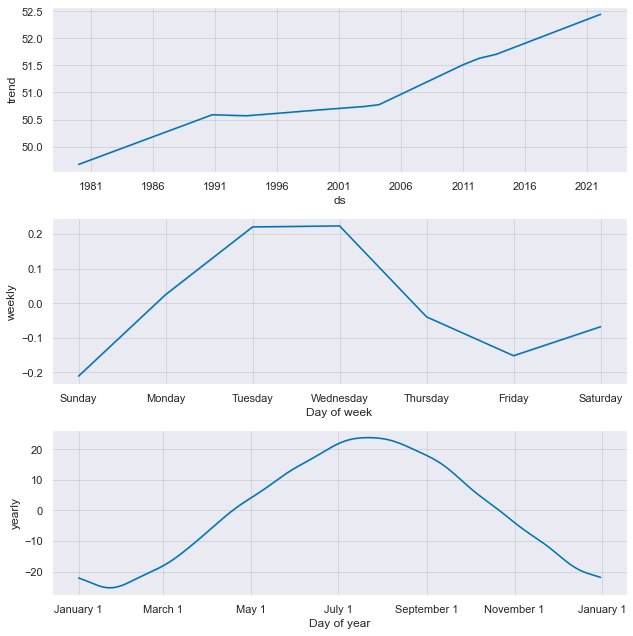

In [25]:
fig2 = m.plot_components(fb_api_forecast)

### Visualize the Actual and Predicted data

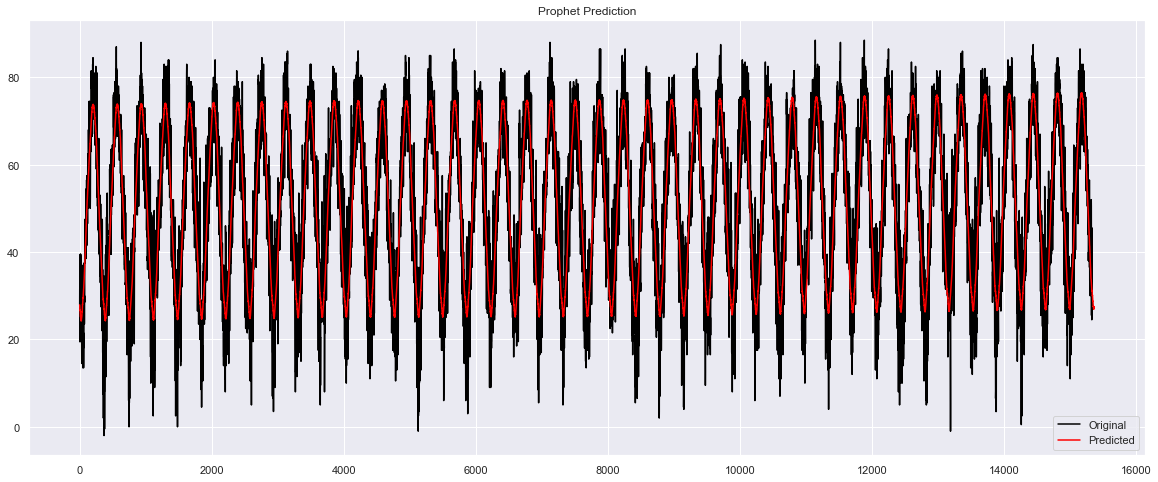

In [26]:
original = df1['y']
pred = fb_api_forecast['yhat']
plt.figure(figsize = (20,8))
plt.title('Prophet Prediction')
plt.plot(original, label = 'Original', color = 'black')
plt.plot(pred, label = 'Predicted', color = 'red')
plt.legend()
plt.show()

### Mean Absolute Error

In [27]:
from sklearn.metrics import mean_absolute_error
        
def mae(y, pred):
    y = y.tolist()
    pred = pred.tolist()
    if len(y) > len(pred):
        long = len(y) - len(pred)
        new_len = y[:len(pred)]
        print('sklearn mean_absolute error: ', mean_absolute_error(new_len, pred))
    else:
        long = len(pred) - len(y)
        new_len = pred[:len(y)]
        print('sklearn mean_absolute error: ', mean_absolute_error(y, new_len))
    act_pred = []
    for i in range(len(new_len)):
        ans = abs(y[i] - pred[i])
        act_pred.append(ans)
    act_pred_sum = sum(act_pred)
    result = (1/len(new_len)) * act_pred_sum
    print('Mean Absolute Error: ', result)

### Mean Absolute Percentage Error

In [28]:
# Mean absolute percentage error

def mape(y, pred):
    y = y.tolist()
    pred = pred.tolist()
    if len(y) > len(pred):
        long = len(y) - len(pred)
        new_len = y[:len(pred)]  
    else:
        long = len(pred) - len(y)
        new_len = pred[:len(y)]
    act_pred = []
    for i in range(len(new_len)):
        if y[i] != 0:
            ans = abs((y[i] - pred[i]) / y[i])
            act_pred.append(ans)
        else:
            continue
    act_pred_sum = sum(act_pred)
    m = (1/len(new_len)) * act_pred_sum
    result = m * 100
    print('Mean Absolute Percentage Error: ', result)

### MAE and MAPE with 30 future prediction

In [29]:
original = df1['y']
pred = fb_api_forecast['yhat']
# Mean Absolute Error 
mae(original, pred)
# Mean Absolute Percentage Error
mape(original, pred)

sklearn mean_absolute error:  5.970361805488448
Mean Absolute Error:  5.97036180548841
Mean Absolute Percentage Error:  18.844614004648808


___

# Prophet Analysis 2: Using Linear Growth

### Creating prophet object and training on data

In [30]:
from fbprophet.diagnostics import cross_validation

model = Prophet(growth = 'linear')
model.fit(df1)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### Creating the future dates that prophet will predict. Specify the frequency as daily because we have daily data
* I'm just predicting 30 dates into the future here

In [31]:
future = model.make_future_dataframe(freq = 'D', periods = 30)

### Predicting the values

In [33]:
forecast = model.predict(future)
#forecast

In [34]:
forecast[['ds','yhat_lower', 'yhat', 'yhat_upper']].tail(30)

,ds,yhat_lower,yhat,yhat_upper
15341,2022-01-01,20.508130,30.310321,39.958283
15342,2022-01-02,20.761380,30.005234,39.656530
15343,2022-01-03,19.717131,30.071699,39.702433
15344,2022-01-04,20.830596,30.092090,39.700928
15345,2022-01-05,19.691015,29.913748,39.143730
15346,2022-01-06,20.176576,29.464561,38.589482
15347,2022-01-07,19.506940,29.161546,39.253981
15348,2022-01-08,19.156988,29.051321,38.697232
15349,2022-01-09,18.934559,28.713089,38.507082
15350,2022-01-10,19.202460,28.752884,38.670981


### New Prediction
* Predicting the month of November

In [35]:
model = Prophet(growth = 'linear',seasonality_mode = 'additive',changepoint_prior_scale = 30,seasonality_prior_scale = 35,daily_seasonality = False,weekly_seasonality = True).add_seasonality(name = 'daily',period = 1,fourier_order = 15).add_seasonality(
                name = 'weekly',
                period = 7,
                fourier_order = 20)

In [36]:
model.fit(df1)

In [37]:
future_30_days = model.make_future_dataframe(freq = 'D', periods = 30)

In [39]:
forecast_30_days = model.predict(future_30_days)
#forecast_30_days

In [40]:
forecast_30_days[['ds','yhat_lower', 'yhat', 'yhat_upper']].tail(30)

,ds,yhat_lower,yhat,yhat_upper
15341,2022-01-01,21.754909,31.091421,40.545457
15342,2022-01-02,21.204042,30.788812,40.583765
15343,2022-01-03,20.874453,30.857729,40.784435
15344,2022-01-04,21.692112,30.880584,40.435978
15345,2022-01-05,20.818832,30.704774,40.350371
15346,2022-01-06,20.527183,30.258029,39.902474
15347,2022-01-07,19.767945,29.957376,39.732917
15348,2022-01-08,20.370439,29.849975,39.380870
15349,2022-01-09,19.324788,29.513792,39.615257
15350,2022-01-10,19.843811,29.555508,39.770966


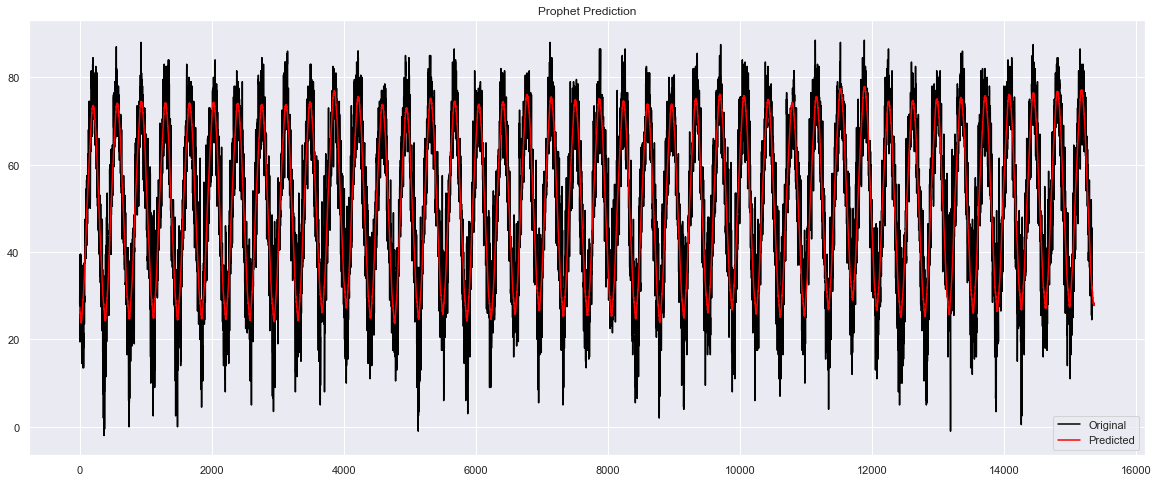

In [41]:
# Visualize
pred = forecast_30_days['yhat']
plt.figure(figsize = (20,8))
plt.title('Prophet Prediction')
plt.plot(df1['y'], label = 'Original', color = 'black')
plt.plot(pred, label = 'Predicted', color = 'red')
plt.legend()
plt.show()

In [42]:
mape(df1['y'], forecast_30_days['yhat'])
mae(df1['y'], forecast_30_days['yhat']) 

Mean Absolute Percentage Error:  18.696401483717356
sklearn mean_absolute error:  5.9420775626633295
Mean Absolute Error:  5.94207756266328


In [43]:
# Just fyi the mae and mape with the 30 day prediction and without that additional data produce the same mape and mae

___

# Prophet Analysis 3: Using Logistic Growth

### Creating a prophet object

### Must have a cap (the max). It is currently 4629 but my guess is that in the beginning of the year it's a lot higher so I'll just do 12,000 to be safe
### Creating the floor and cap for the dataframe, df3

In [44]:
df1['floor'] = 0.0
df1['cap'] = 90.0

<ipython-input-44-2fbefbc3032b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['floor'] = 0.0
<ipython-input-44-2fbefbc3032b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['cap'] = 90.0


### Creating a new dataframe with new periods (this is November 2020)

In [45]:
future_logistic = model.make_future_dataframe(freq = 'D', periods = 30)

### Creating a prophet object 

In [46]:
future_logistic['floor'] = 0.0
future_logistic['cap'] = 90.00

model_logistic = Prophet(growth='logistic')
model_logistic.fit(df1)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### Predicting the values

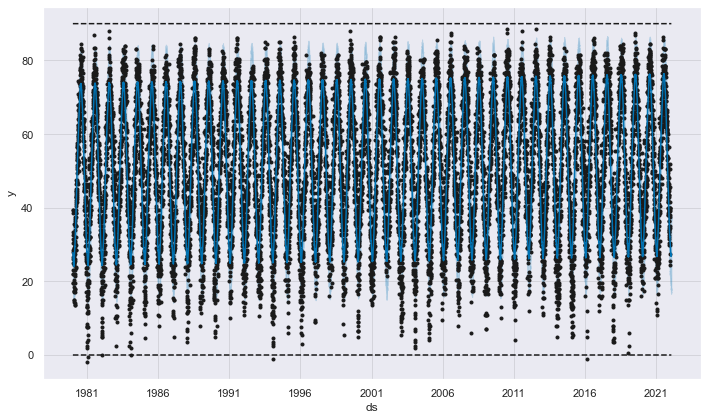

In [47]:
forecast_logistic = model_logistic.predict(future_logistic)
fig = model_logistic.plot(forecast_logistic)

In [48]:
mae(df1['y'],forecast_logistic['yhat'])
mape(df1['y'],forecast_logistic['yhat'])

sklearn mean_absolute error:  5.971745653393359
Mean Absolute Error:  5.97174565339341
Mean Absolute Percentage Error:  18.84461052491382


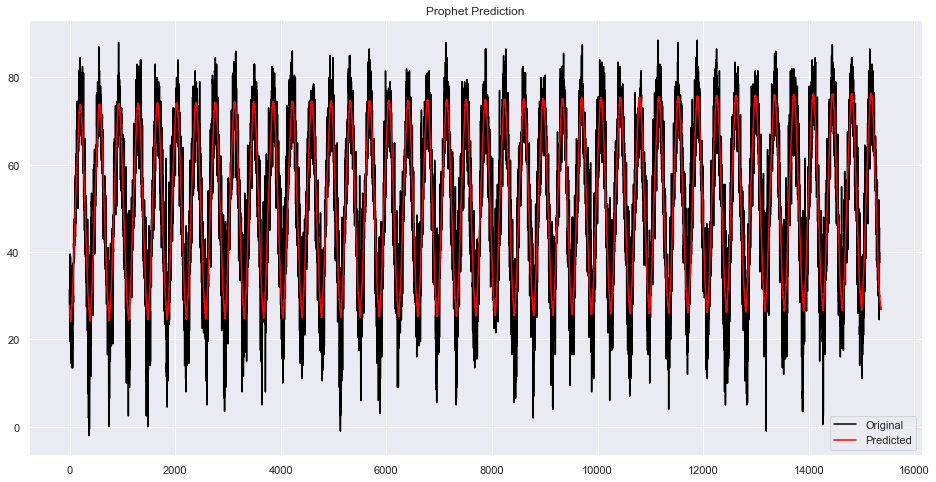

In [49]:
# Visualize
pred = forecast_logistic['yhat']
plt.figure(figsize = (16,8))
plt.title('Prophet Prediction')
plt.plot(df1['y'], label = 'Original', color = 'black')
plt.plot(pred, label = 'Predicted', color = 'red')
plt.legend()
plt.show()

In [51]:
model_logistic = Prophet(growth = 'logistic',seasonality_mode = 'additive',changepoint_prior_scale = 30,seasonality_prior_scale = 35,daily_seasonality = False,weekly_seasonality = True).add_seasonality(name = 'daily',period = 1,fourier_order = 15).add_seasonality(name = 'weekly', period = 7, fourier_order = 20)
model_logistic.fit(df1)
future_logistic_30_days = model_logistic.make_future_dataframe(freq = 'D', periods = 30)
future_logistic_30_days['floor'] = 0.0
future_logistic_30_days['cap'] = 90.00

In [52]:
forecast_logistic_30_days = model_logistic.predict(future_logistic_30_days)

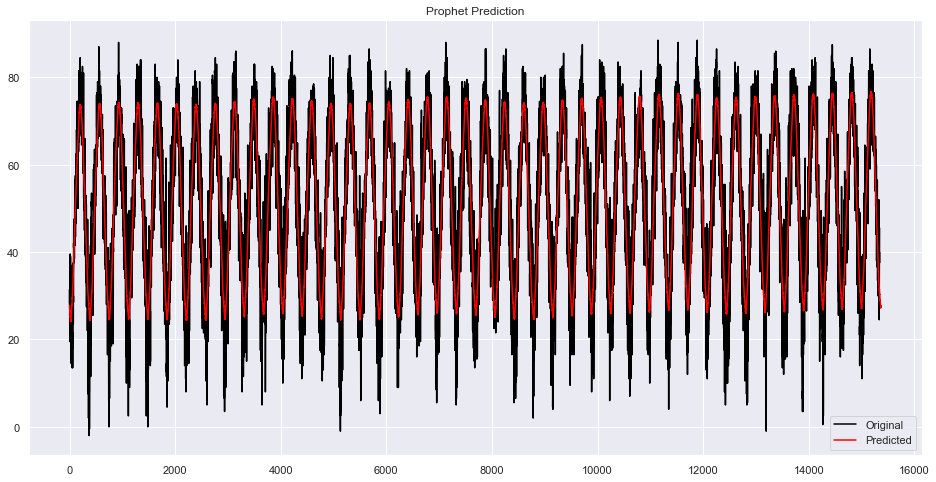

In [53]:
pred = forecast_logistic_30_days['yhat']
plt.figure(figsize = (16,8))
plt.title('Prophet Prediction')
plt.plot(df1['y'], label = 'Original', color = 'black')
plt.plot(pred, label = 'Predicted', color = 'red')
plt.legend()
plt.show()

In [54]:
mape(df1['y'], forecast_logistic_30_days['yhat'])
mae(df1['y'], forecast_logistic_30_days['yhat'])

Mean Absolute Percentage Error:  18.785377931242607
sklearn mean_absolute error:  5.961678085498003
Mean Absolute Error:  5.961678085498038


___

# Prophet Analysis 4

# Prophet white paper: https://peerj.com/preprints/3190.pdf

* Prophet uses additive model
    * y(t) = g(t) + s(t) + h(t) + $ϵ_{t}$
    * g(t) : trend
    * s(t) : periodic component
    * h(t) : holiday related events
    * $ϵ_{t}$ : error

* The syntax is similar to scikit-learn with calls to the fit and predict functions.
* Need to make a new data frame for forecasting via the make_future_dataframe function. 
    * The parameter freq controls the frequency (e.g. ‘D’ for days, ‘M’ for months)

In [55]:
model_new = Prophet()
model_new.fit(df1)
future_new = model_new.make_future_dataframe(periods=30, freq='D')
forecast_new = model_new.predict(future_new)
#forecast_new

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


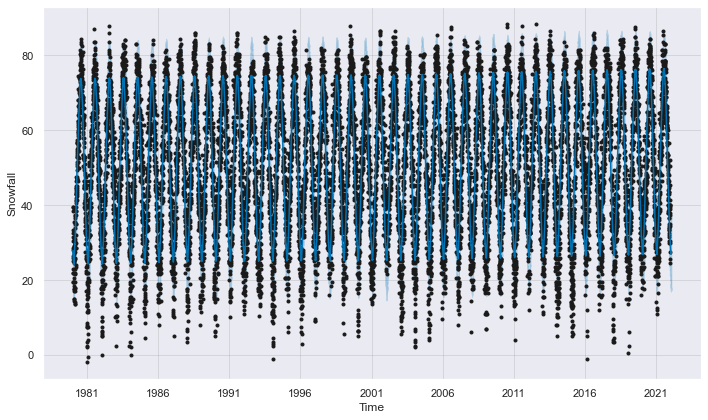

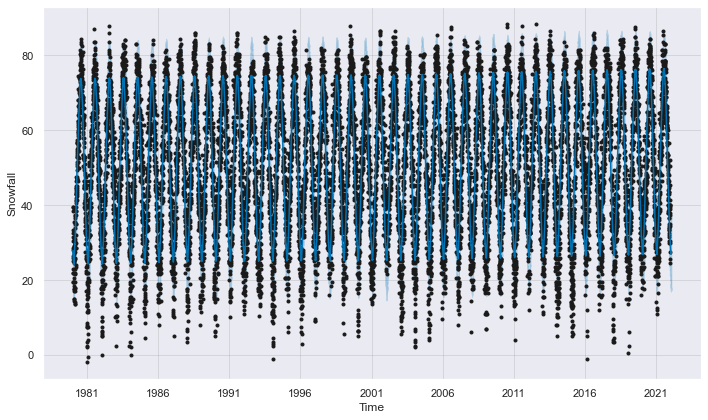

In [56]:
model_new.plot(forecast_new,xlabel='Time', ylabel='Snowfall')

In [57]:
### Looking at my MAE and MAPE functions
mape(df1['y'], forecast_new['yhat'])
mae(df1['y'], forecast_new['yhat'])

Mean Absolute Percentage Error:  18.844614004648808
sklearn mean_absolute error:  5.970361805488448
Mean Absolute Error:  5.97036180548841


### Trying multiplicative model

In [59]:
model_new_mult = Prophet(seasonality_mode='multiplicative')
model_new_mult.fit(df1)
future_new_mult = model_new_mult.make_future_dataframe(periods=30, freq='D')
forecast_new_mult = model_new_mult.predict(future_new_mult)
#forecast_new_mult

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


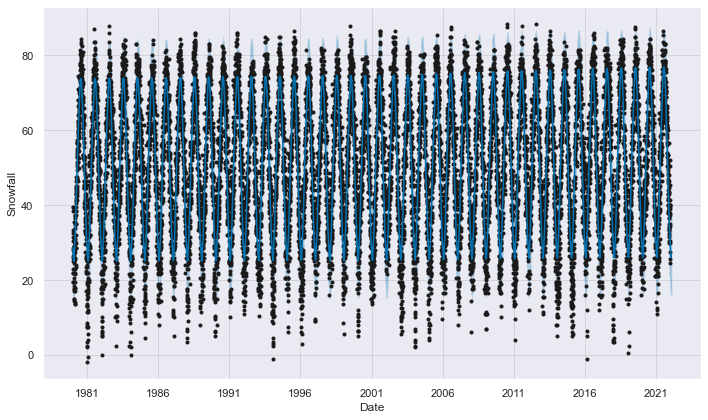

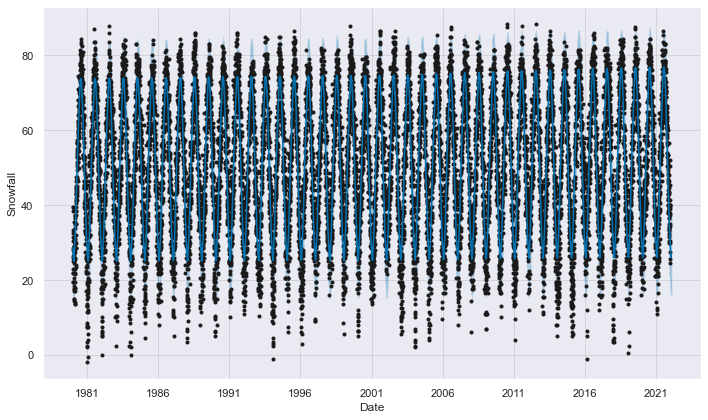

In [60]:
model_new_mult.plot(forecast_new_mult,xlabel='Date', ylabel='Snowfall')

In [61]:
### Looking at my MAE and MAPE functions
mape(df1['y'], forecast_new_mult['yhat'])
mae(df1['y'], forecast_new_mult['yhat'])

Mean Absolute Percentage Error:  18.870613661962928
sklearn mean_absolute error:  5.970609750113443
Mean Absolute Error:  5.9706097501134225


## Trend Change Points
* The trend in a real time series can change abruptly. 
* Prophet attempts to detect these changes automatically using a Laplacian or double exponential prior. 
* By default, the change points are only fitted for the 1st 80% of the time series, allowing sufficient runway for the actual forecast. 
* These outliers should ideally be removed. Let’s display the change points detected by Prophet:

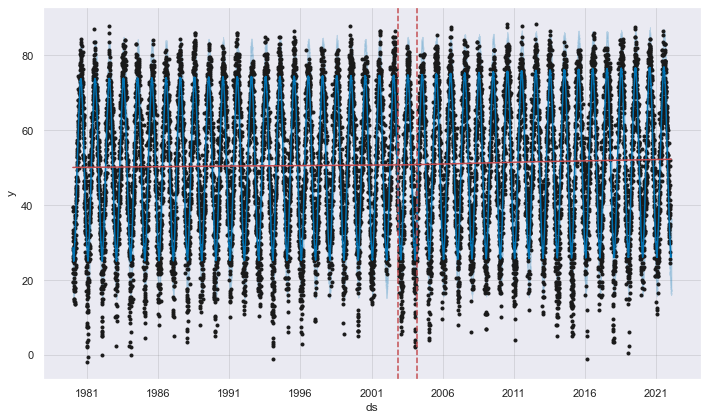

In [62]:
from fbprophet.plot import add_changepoints_to_plot

fig_model_new_mult = model_new_mult.plot(forecast_new_mult)
a = add_changepoints_to_plot(fig_model_new_mult.gca(), model_new_mult, forecast_new_mult)

### changepoint_prior_scale
* To adjust the trend change, use the parameter changepoint_prior_scale
* Set to 0.05 by default. 
* Increasing its value would make the trend more flexible and reduce underfitting, at the risk of overfitting. 

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


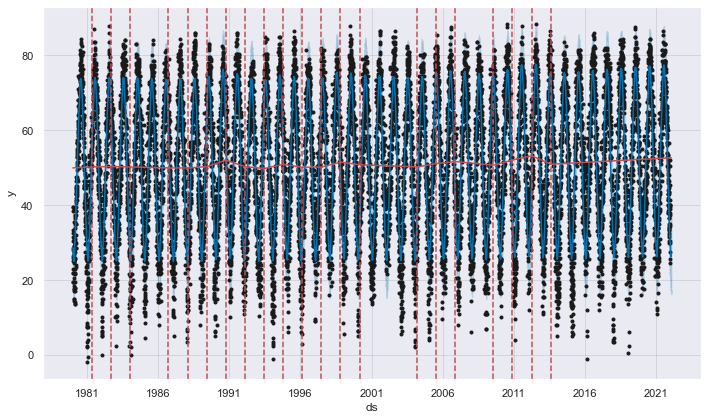

In [63]:
from fbprophet.plot import add_changepoints_to_plot


model_new_mult_2 = Prophet(seasonality_mode='multiplicative', changepoint_prior_scale = 0.5)
model_new_mult_2.fit(df1)
future_new_mult_2 = model_new_mult_2.make_future_dataframe(periods=30, freq='D')
forecast_new_mult_2 = model_new_mult_2.predict(future_new_mult_2)

fig_model_new_mult_2 = model_new_mult_2.plot(forecast_new_mult_2)
a_2 = add_changepoints_to_plot(fig_model_new_mult_2.gca(), model_new_mult_2, forecast_new_mult_2)

### plot_components
* Displays the components of the model

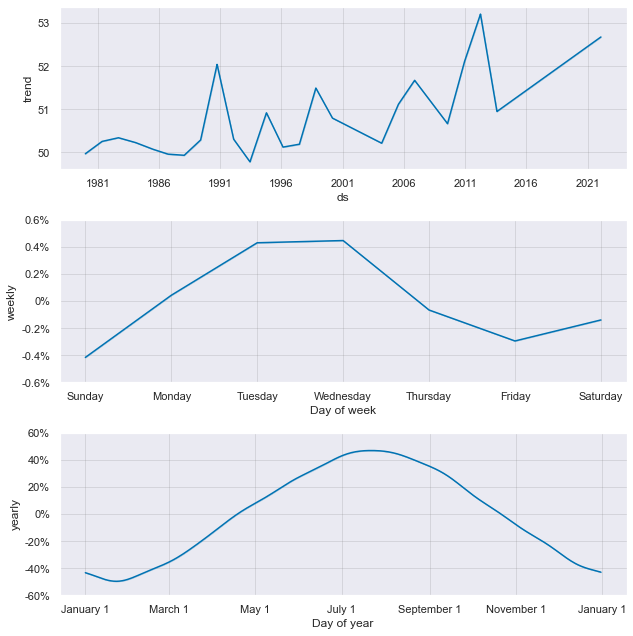

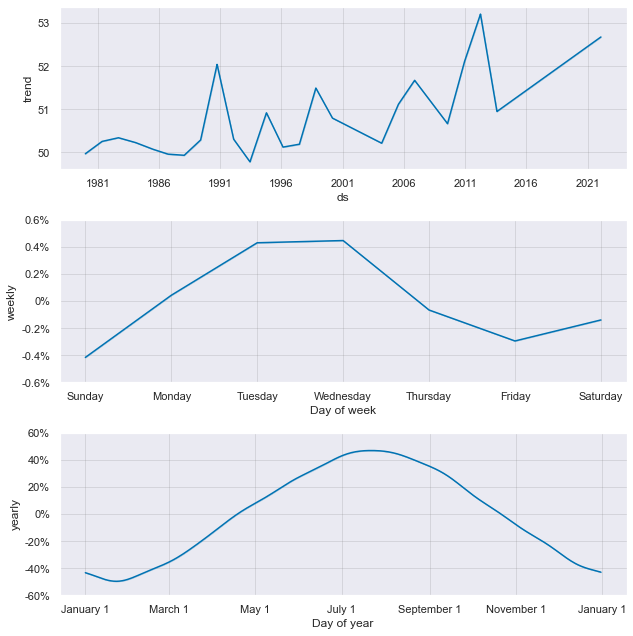

In [64]:
model_new_mult_2.plot_components(forecast_new_mult_2)